In [169]:
#Libraries required
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.metrics import Metric
import tensorflow.compat.v1 as tf
import warnings
warnings.filterwarnings('ignore')

<h2 id="load_dataset">Load the Youtube data</h2>
I have chosen “The Trending YouTube Video Statistics” dataset, which is a daily record statistic for trending YouTube videos. The orginal Dataset includes video title, channel title, publish time, tags, views, likes, and dislikes, description, and comment count.

| Column Description          |
| --------------------------- |
| Link of the video           |
| Trending date               |
| Title of the video          |
| Name of the channel         |
| Category of the video       |
| Date of publishing          |
| Views                       |
| Tags                        |
| Likes                       |
| Dislikes                    |
| Number of comments          |
| Thumbnails                  |
| Comments disabled           |
| Ratings disabled            |
| Error video or removed      |
| Video description           |
| Trending day                |
| Trending month              |
| Trending year               |
| Trending wdays              |
| Video time publishing       |


### Load Data From CSV File


In [170]:
#Load the dataset
df = pd.read_csv("C://Users//kikis//Desktop//LASTYYYEAR//ml TESSERA//Nuova cartella//AI AND ML//cleanedDF.csv",  delimiter=";", encoding="ISO-8859-1")

#We can take a look to the dataset
df.head()
#We can easy analize the type of every column
print(df.dtypes)
#I print the maximum (and the minimum) number of views of a video in GB
print("Tha maximum number of views of a Great Bretain video is:", df['Views'].max())
print("Tha minimum number of views of a Great Bretain video is:", df['Views'].min())

Link of the video         object
Trending Date             object
Title of the video        object
Name of the channel       object
Category of the video      int64
Date of publishing        object
Tags                      object
Views                      int64
Likes                      int64
Dislikes                   int64
Number of comments         int64
Thumbnails                object
Comments disabled           bool
Ratings disabled            bool
Error video or removed      bool
Video description         object
Trending day               int64
Trending month             int64
Trending year              int64
Trending wdays            object
Video time publishing     object
dtype: object
Tha maximum number of views of a Great Bretain video is: 9189544
Tha minimum number of views of a Great Bretain video is: 851


In [171]:
#Since the time column is expressed in hours, minutes and seconds, I want to extrapolate only the hours
df['Video time publishing'] = pd.to_timedelta(df["Video time publishing"]).dt.components.iloc[:, 1:4]

The publication time is useful because, depending on this, we can see when it is preferable to publish a video, in order to increase the number of views. Another interesting fact is the days of the week: depending on the day, the video could be a very successful or not.

In [172]:
#I have created a subset that contains only the columns that are significant for my analysis. The 'Title of the video' column, for example, 
#will not give me any useful information, since the title will be different for each published video. 
#Furthermore, it is impossible to predict what Title, a person, will want to give to his/her video.
cdf = df[['Category of the video','Views','Likes', 'Dislikes','Trending wdays', 'Video time publishing']]
cdf.head(9)
#I convert the data type of the 2 columns, in order to manage them as categoric data.
cdf['Trending wdays'].astype('category')
cdf['Video time publishing'].astype('category')


0         7
1         6
2         2
3        17
4        19
         ..
30397    16
30398    16
30399    16
30400    17
30401     4
Name: Video time publishing, Length: 30402, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [173]:
cdf.head()
print(f"There are {cdf.shape[0]} rows and {cdf.shape[1]} columns in the dataset.")


There are 30402 rows and 6 columns in the dataset.


I would like to predict the number of views of a video should have based on the other characteristics.

In [174]:
#It is possible to notice the degree of correlation of the variables with the target variable Y, 
#which corresponds to the number of views of a video.
correlation_matrix = cdf.corr()
correlation_matrix["Views"]

Category of the video   -0.228182
Views                    1.000000
Likes                    0.686275
Dislikes                 0.331922
Video time publishing   -0.064275
Name: Views, dtype: float64

Negative correlation is a relationship between two variables in which one variable increases as the other decreases, and vice versa. In statistics, a perfect negative correlation is represented by the value -1.0, while a 0 indicates no correlation, and +1.0 indicates a perfect positive correlation. The variable that seems to be most correlated is the one represented by the number of Likes.

In [175]:
pd.options.mode.chained_assignment = None  #default='warn'

tot = cdf[ (cdf['Trending wdays'] == 'Saturday') ].count()
print(tot)

new = cdf[ (cdf['Trending wdays'] == 'Saturday') ].index
print(new)
cdf.drop(new , inplace=True)
print(cdf)

Category of the video    4505
Views                    4505
Likes                    4505
Dislikes                 4505
Trending wdays           4505
Video time publishing    4505
dtype: int64
Int64Index([  712,   713,   714,   715,   716,   717,   718,   719,   720,
              721,
            ...
            29742, 29743, 29744, 29745, 29746, 29747, 29748, 29749, 29750,
            29751],
           dtype='int64', length=4505)
       Category of the video    Views   Likes  Dislikes Trending wdays  \
0                         26  7224515   55681     10247        Tuesday   
1                         24  1053632   25561      2294        Tuesday   
2                         17    27833     193        12        Tuesday   
3                         24  1182775   52708      1431        Tuesday   
4                         22  1164201   57309       749        Tuesday   
...                      ...      ...     ...       ...            ...   
30397                     24  2665975   26126

In [176]:
pd.options.mode.chained_assignment = None  # default='warn'

tot = cdf[ (cdf['Trending wdays'] == 'Friday') ].count()
print(tot)

new = cdf[ (cdf['Trending wdays'] == 'Friday') ].index
print(new)
cdf.drop(new , inplace=True)
print(cdf)

Category of the video    4326
Views                    4326
Likes                    4326
Dislikes                 4326
Trending wdays           4326
Video time publishing    4326
dtype: int64
Int64Index([  527,   528,   529,   530,   531,   532,   533,   534,   535,
              536,
            ...
            29616, 29617, 29618, 29619, 29620, 29621, 29622, 29623, 29624,
            29625],
           dtype='int64', length=4326)
       Category of the video    Views   Likes  Dislikes Trending wdays  \
0                         26  7224515   55681     10247        Tuesday   
1                         24  1053632   25561      2294        Tuesday   
2                         17    27833     193        12        Tuesday   
3                         24  1182775   52708      1431        Tuesday   
4                         22  1164201   57309       749        Tuesday   
...                      ...      ...     ...       ...            ...   
30397                     24  2665975   26126

Since the dataset was large for my computer memory, I decided to delete the rows corresponding to the 'Trending week days' column, as they are negatively correlated with my y. In particular I have eliminated the columns where 'Trending week days' was equal to Saturday and Friday.

By adding up the number of views for the various days of the week for the various rows, it is possible to display 5 macro groups into which I could divide the column of the 'Views'.

In [177]:
cdf.groupby('Trending wdays')['Views'].sum()

Trending wdays
Monday       6788696935
Sunday       6745646236
Thursday     6866959457
Tuesday      7079234780
Wednesday    6893851967
Name: Views, dtype: int64

In [178]:
obs_for_group = cdf.shape[0]/5
print(obs_for_group) #Observation for groups

4314.2


In [179]:
num_mon = cdf[(cdf['Trending wdays'] == 'Monday')].count()
print(num_mon)

num_sun = cdf[(cdf['Trending wdays'] == 'Sunday')].count()
print(num_sun)

num_thu = cdf[(cdf['Trending wdays'] == 'Thursday')].count()
print(num_thu)

num_tue = cdf[(cdf['Trending wdays'] == 'Tuesday')].count()
print(num_tue)

num_wen = cdf[(cdf['Trending wdays'] == 'Wednesday')].count()
print(num_wen)

#I can set 5 categories: 
# 1 --> For Monday
# 2 -->  For Tuesday
# 3 --> For Wednesday
# 4 --> For Thursday
# 5 --> For Sunday

Category of the video    4251
Views                    4251
Likes                    4251
Dislikes                 4251
Trending wdays           4251
Video time publishing    4251
dtype: int64
Category of the video    4295
Views                    4295
Likes                    4295
Dislikes                 4295
Trending wdays           4295
Video time publishing    4295
dtype: int64
Category of the video    4282
Views                    4282
Likes                    4282
Dislikes                 4282
Trending wdays           4282
Video time publishing    4282
dtype: int64
Category of the video    4445
Views                    4445
Likes                    4445
Dislikes                 4445
Trending wdays           4445
Video time publishing    4445
dtype: int64
Category of the video    4298
Views                    4298
Likes                    4298
Dislikes                 4298
Trending wdays           4298
Video time publishing    4298
dtype: int64


I replaced the lines for which the values of the days of the week were Monday, Tuesday, Wednesday, Thursday and Sunday with a categorical value. A categorical variable is a variable whose set of possible values consists of a finite number of categories (2 or more).

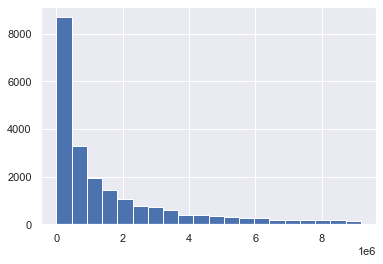

In [180]:
import matplotlib.pyplot as plt
cdf["Views"].hist(bins=20)
plt.show()

The target variable is 'The number of views'. This code uses the pandas plotting functionality to generate a histogram with 20 bins. The decision to use 20 bins is based on a few trials. When defining the number of bins, I should have neither too many observations per bin nor too few. Too few bins can hide certain patterns, while too many bins can make the histogram lack smoothness.

In [181]:
print(cdf.sort_values(by=['Views']))

       Category of the video    Views   Likes  Dislikes Trending wdays  \
3488                      25      922      13         0         Sunday   
3664                      25      937      13         0         Monday   
3868                      25      972      13         0        Tuesday   
4064                      25      983      13         0      Wednesday   
4256                      25     1014      13         1       Thursday   
...                      ...      ...     ...       ...            ...   
28517                     10  9162725  410491     10837      Wednesday   
12341                     10  9164600  196128     24541       Thursday   
23985                      1  9170381   58491      2125       Thursday   
21407                     17  9174835   93395     18690         Monday   
14178                     24  9177109     934       115         Monday   

       Video time publishing  
3488                      18  
3664                      18  
3868              

In [182]:
#One-hot encode using pandas get_dummies
#The categorical data must be converted to a numerical form.
cdf = pd.get_dummies(cdf)
cdf.iloc[:,5:].head(10)

,Trending wdays_Monday,Trending wdays_Sunday,Trending wdays_Thursday,Trending wdays_Tuesday,Trending wdays_Wednesday
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
5,0,0,0,1,0
6,0,0,0,1,0
7,0,0,0,1,0
8,0,0,0,1,0
9,0,0,0,1,0


The number of Views does not represent a categorical or binary variable: to deal with it I decided to create a new Views_1 column: in particular it will be a categorical variable. The first class will contain videos with a number of views between 851 and 3000000, the second class will contain videos with a number of views included between 3000000 and 6000000, finally there will be the class with views included between 6000000 and 920000. 

In [183]:
cdf.loc[(cdf['Views'] >= 851) & (cdf['Views'] <= 3000000), 'Views_1']= 1
cdf.loc[(cdf['Views'] >= 3000000) & (cdf['Views'] <= 6000000), 'Views_1']= 2
cdf.loc[(cdf['Views'] >= 6000000) & (cdf['Views'] <= 9200000), 'Views_1']= 3
print(cdf.head())

   Category of the video    Views  Likes  Dislikes  Video time publishing  \
0                     26  7224515  55681     10247                      7   
1                     24  1053632  25561      2294                      6   
2                     17    27833    193        12                      2   
3                     24  1182775  52708      1431                     17   
4                     22  1164201  57309       749                     19   

   Trending wdays_Monday  Trending wdays_Sunday  Trending wdays_Thursday  \
0                      0                      0                        0   
1                      0                      0                        0   
2                      0                      0                        0   
3                      0                      0                        0   
4                      0                      0                        0   

   Trending wdays_Tuesday  Trending wdays_Wednesday  Views_1  
0                

In [184]:
cdf.isna().sum()

Category of the video       0
Views                       0
Likes                       0
Dislikes                    0
Video time publishing       0
Trending wdays_Monday       0
Trending wdays_Sunday       0
Trending wdays_Thursday     0
Trending wdays_Tuesday      0
Trending wdays_Wednesday    0
Views_1                     0
dtype: int64

In [185]:
cdf['Views_1'] = cdf['Views_1'].astype(int)


# Train & Test

My analysis could be a regression problem because I would like to predict the number of views based on the other characteristics. I would turn it into a classification problem, creating classes with the number of views, 
for example from 0 to 3000000 views is the least viral class and so on.
In this way it would become a class assignment problem.
Since I want to make a classification I will use the KNN algorithm.

The K-nearest neighbors (KNN) algorithm is a type of supervised machine learning algorithms. KNN is extremely easy and yet performs quite complex classification tasks. It is a lazy learning algorithm since it doesn't have a specialized training phase. Rather, it uses all of the data for training while classifying a new data point or instance. 

Classification is a classic machine learning application. Classification categorises the output in two classes.
But what if you want to classify something that has more than 2 categories?
This is where multi-class classification comes in. MultiClass classification can be defined as the classifying instances into one of three or more classes. I am going to do multi-class classification using K Nearest Neighbours. KNN is a super simple algorithm, which assumes that similar things are in close proximity of each other. So if a datapoint is near to another datapoint, it assumes that they both belong to similar classes. 

In [186]:
#Other libraries
import statsmodels.api as sm
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

In [187]:
#The X variable contains the columns of the ds (but not y) while y contains the labels.
X = cdf['Views_1']
#I remove the variable labels from the df with the drop() function
Y = cdf.drop('Views_1', axis = 1)
Y = cdf.drop('Views', axis = 1)
#The two columns Views and Views_1 represent the same thing. I expect the class will be predicted using the other factors.
#Convert X variables to dummy variables
X = pd.get_dummies(X, drop_first=True)  
print(X)

       2  3
0      0  1
1      0  0
2      0  0
3      0  0
4      0  0
...   .. ..
30397  0  0
30398  0  1
30399  0  0
30400  0  0
30401  0  0

[21571 rows x 2 columns]


In [188]:
#Train and test: To avoid over-fitting, I will divide our dataset into training and test splits, which gives us a better idea as to
#how our algorithm performed during the testing phase. 
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.30,random_state=42) # 70% train set and 30% test set

print(X_train.shape,X_test.shape)

(15099, 2) (6472, 2)


It is always a good practice to scale the features so, all of them, can be uniformly evaluated. Wikipedia explains the reasoning:
"Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. For example, the majority of classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance."

In [189]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

The first step is to import the KNeighborsClassifier class from the sklearn.neighbors library. Then, the class is initialized with the parameter n_neigbours. This is the value for the K. There is no ideal value for K and it is selected after testing and evaluation, however I will choose 5 that seems to be the most commonly used value for KNN algorithm.

In [196]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=5)
#The MultiOutputClassifier is a strategy consists of fitting one classifier per target. 
#This is a simple strategy for extending classifiers that do not natively support multi-target classification.

classifier = MultiOutputClassifier(knn, n_jobs=-1)
           
classifier.fit(X_train, y_train)
#By fitting a model we find the optimal values for the fixed parameters using some algorithm. 

MultiOutputClassifier(estimator=KNeighborsClassifier(), n_jobs=-1)

# Predicting Test Data

In [197]:
#Predictions on test data.
y_pred = classifier.predict(X_test)
print(y_pred)

[[   10 82466  1559 ...     0     0     2]
 [   10 82466  1559 ...     0     0     2]
 [   24  1032    67 ...     0     0     1]
 ...
 [   24  1032    67 ...     0     0     1]
 [   24  1032    67 ...     0     0     1]
 [   24  1032    67 ...     0     0     1]]


# Evaluating the Model

For estimation of the metric over a stream of data, the function creates an update_op operation that returns the precision_at_<k>. Internally, a top_k operation computes a Tensor indicating the top k predictions. Set operations applied to top_k and labels calculate the true positives and false positives weighted by weights. Then update_op increments true_positive_at_<k> and false_positive_at_<k> using these values.

In [192]:
tf.disable_v2_behavior()
metric = tf.compat.v1.metrics.average_precision_at_k(y_test, y_pred, 2)

sess = tf.Session()
sess.run(tf.local_variables_initializer())

precision, update = sess.run(metric)
print(precision)

metric_1 = tf.compat.v1.metrics.average_precision_at_k(y_test, y_pred, 3)

sess = tf.Session()
sess.run(tf.local_variables_initializer())

precision, update = sess.run(metric_1)
print(precision)

0.5784147095179234
0.5838483724763035


The results show that KNN algorithm was able to classify the records in the test set, of the type 3 (Views between 6000000 e 920000000) , with 58% of accuracy, which is low. I can see the accuracy also for the other categories.

KNN performs better with a lower number of features than a large number of features. I can say that when the number of features increases than it requires more data. Increase in dimension also leads to the problem of overfitting. To avoid overfitting, the data will need to grow exponentially the number of dimensions increase. 

In [193]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    classifier = MultiOutputClassifier(knn, n_jobs=-1)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test)) 

At each iteration the mean error for predicted values of test set is calculated and the result is appended to the error list.

I have to plot the error values against K values:

Text(0, 0.5, 'Mean Error')

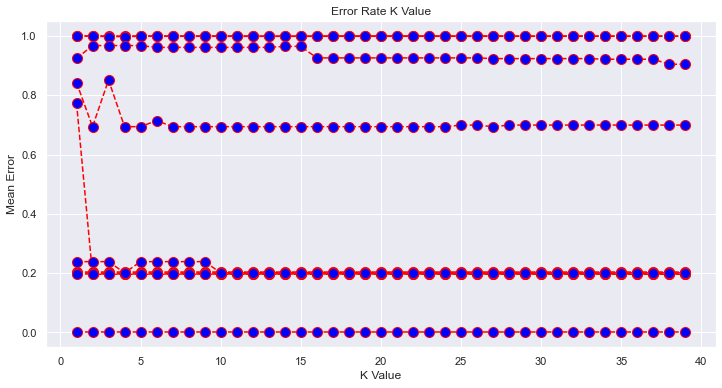

In [194]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

From the output we can see that the mean error is zero when the value of the K is between 0 and 40 for the first category.
The mean error is between 0,2 and 0,9 when the value of the K is between 0 and 40 for the second category.

I should implement the KNN algorithm for a different classification dataset. Vary the test and training size along with the K value to see how your results differ and how can I improve the accuracy of your algorithm. 

I know that a 'Classification' is a prediction task with a categorical target variable. Classification models learn how to classify any new observation. This assigned class can be either right or wrong, not in between. Here I am trying to predict the number of views of a videos, based on the other characteristics. 

A great thing about model-tuning tools is that many of them are not only applicable to the kNN algorithm, but they also apply to many other machine learning algorithms. 
The accuracy is not high because KNN performs best with a low number of features.